## Imports

In [1]:
import pandas as pd
from icecream import ic
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

## Load Dataset

In [2]:
source_filepath = '../datasets/oecd-population.csv'
target_filepath = '../plots'
oecd_pop_df = pd.read_csv(source_filepath)

In [3]:
oecd_pop_df.shape

(92907, 11)

In [4]:
oecd_pop_df['Age'].unique()

array(['2 years', '3 years', '4 years', '5 years', '6 years', '7 years',
       '8 years', '9 years', '10 years', '11 years', '12 years',
       '13 years', '14 years', '15 years', '16 years', '17 years',
       '18 years', '19 years', '20 years', '21 years', '22 years',
       '23 years', '24 years', '25 years', '26 years', '27 years',
       '28 years', '29 years', '30 years', '31 years', '32 years',
       '33 years', '34 years', '35 years', '36 years', '37 years',
       '38 years', '39 years', '40 years', '41 years', '42 years',
       '43 years', '44 years', '45 years', '46 years', '47 years',
       '48 years', '49 years', 'From 50 to 54 years',
       'From 55 to 59 years', 'From 60 to 64 years', '65 years or over',
       '1 year', 'From 10 to 14 years', '0 years', 'Total', 'Unknown'],
      dtype=object)

In [5]:
oecd_pop_df.head()

,COUNTRY,Country,SEX,Gender,AGE,Age,YEAR,Year,Value,Flag Codes,Flags
0,AUS,Australia,F,Female,Y2,2 years,2000,2000,122824.0,NaN,NaN
1,AUS,Australia,F,Female,Y2,2 years,2005,2005,123149.0,NaN,NaN
2,AUS,Australia,F,Female,Y2,2 years,2010,2010,142144.0,NaN,NaN
3,AUS,Australia,F,Female,Y2,2 years,2011,2011,142664.0,NaN,NaN
4,AUS,Australia,F,Female,Y2,2 years,2012,2012,145990.0,NaN,NaN


## Data Preprocessing

In [6]:
selected_country = 'Australia'
group_age_by = 20
include_65_above = True

In [7]:
cols_of_interest = ['Country', 'Gender', 'Age', 'Year', 'Value']
oecd_pop_df = oecd_pop_df[cols_of_interest]
oecd_pop_df = oecd_pop_df[oecd_pop_df['Gender'] == 'Total']
oecd_pop_df.head()

,Country,Gender,Age,Year,Value
56754,Denmark,Total,49 years,2000,74165.0
56755,Denmark,Total,49 years,2005,73449.0
56756,Denmark,Total,49 years,2010,76363.0
56757,Denmark,Total,49 years,2011,76264.0
56758,Denmark,Total,49 years,2012,78320.0


In [8]:
oecd_pop_df['Year'].unique()

array([2000, 2005, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021])

In [9]:
country_pop = oecd_pop_df.query('Country == @selected_country').drop(['Country'], axis=1)
country_pop.head()

,Gender,Age,Year,Value
57073,Total,36 years,2000,297614.0
57074,Total,36 years,2005,299111.0
57075,Total,36 years,2010,309717.0
57076,Total,36 years,2011,305275.0
57077,Total,36 years,2012,304389.0


In [10]:
def create_age_groups(group_age_by):
    reference_age = 65
    ages_dict = dict()

    get_age_label = lambda *args: \
        f'{args[0]} years' if args[0] == args[1] else f'{age-group_age_by} years to {age-1} years'

    age = reference_age
    if age >= 65: 
        ages_label = ages_inds = '65 years or over'
        ages_dict[ages_inds] = ages_label
        ic(f'{ages_inds}: {ages_label}')
    while (age > 50):
        ages_label = get_age_label(age-group_age_by, age-1)
        ages_inds = []
        for init_age in range(age-group_age_by, age, 5):
            if init_age+5 > 50:
                ages_inds.insert(0, f'From {init_age} to {init_age+5-1} years')
            else:
                ages_inds.extend([f'{i} years' for i in range(init_age, init_age+5)])
        ages_dict[tuple(ages_inds)] = ages_label
        age -= group_age_by
        ic(f'{ages_inds}: {ages_label}')
    while(age > 0 and age >= group_age_by):
        ages_inds = [f'{i} years' for i in range(age-group_age_by, age)]
        ages_label = f'{get_age_label(age-group_age_by, age-1)}'
        ages_dict[tuple(ages_inds)] = ages_label
        ic(f'{ages_inds}: {ages_label}')
        age -= group_age_by
    if age > 0:
        ages_label = f'below {age} years'
        ages_inds = [f'{i} years' for i in range(0, age)]
        ages_dict[tuple(ages_inds)] = ages_label
        ic(f'{ages_inds}: {ages_label}')

    return ages_dict

In [11]:
def replace_column_names(col_name, group_age_by):
    ref_dict = create_age_groups(group_age_by)
    for key, label in ref_dict.items():
        if col_name in key:
            return label

In [12]:
import re
ic.disable()

country_pop_procced_df = country_pop.copy()

#preprocessing for groupby step
age_groups = list(create_age_groups(group_age_by).values())
country_pop_procced_df['Age'] = country_pop_procced_df['Age'].apply(replace_column_names, group_age_by=group_age_by)
country_pop_procced_df = country_pop_procced_df.loc[country_pop_procced_df['Age'].isin(age_groups)]

get_nums = lambda str: tuple([int(match) for match in re.findall(r'\d+', str)])
country_pop_procced_df['tempAge'] = country_pop_procced_df['Age'].apply(get_nums)
if not include_65_above:
    country_pop_procced_df = country_pop_procced_df[country_pop_procced_df['tempAge'] != (65,)]
country_pop_procced_df = country_pop_procced_df.sort_values(['Year', 'tempAge'])

ages_list = country_pop_procced_df['Age'].unique()

#Groupby
country_pop_procced_df = country_pop_procced_df.groupby(['Year', 'tempAge', 'Age'])['Value'].sum()
country_pop_procced_df = country_pop_procced_df.sort_index(level=[0, 1]).droplevel('Age')

country_pop_procced_df

Year  tempAge 
2000  (5,)        1021370.0
      (5, 24)     4998840.0
      (25, 44)    5792275.0
      (45, 64)    4333285.0
2005  (5,)        1023643.0
      (5, 24)     5238466.0
      (25, 44)    5849115.0
      (45, 64)    4938279.0
2010  (5,)        1160602.0
      (5, 24)     5533705.0
      (25, 44)    6263101.0
      (45, 64)    5518174.0
2011  (5,)        1163498.0
      (5, 24)     5551968.0
      (25, 44)    6355485.0
      (45, 64)    5597893.0
2012  (5,)        1199690.0
      (5, 24)     5604772.0
      (25, 44)    6479956.0
      (45, 64)    5646580.0
2013  (5,)        1217446.0
      (5, 24)     5663390.0
      (25, 44)    6596790.0
      (45, 64)    5711051.0
2014  (5,)        1230015.0
      (5, 24)     5724341.0
      (25, 44)    6679330.0
      (45, 64)    5782144.0
2015  (5,)        1244275.0
      (5, 24)     5779914.0
      (25, 44)    6766485.0
      (45, 64)    5849554.0
2016  (5,)        1261582.0
      (5, 24)     5853563.0
      (25, 44)    6842619.0
     

In [13]:
# country_pop_procced_df = country_pop_procced_df[country_pop_procced_df['tempAge'] != (65,)]
# country_pop_procced_df

/var/folders/pt/7c62stp91n90_kb8qmmqs5d00000gn/T/ipykernel_3791/1159560893.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


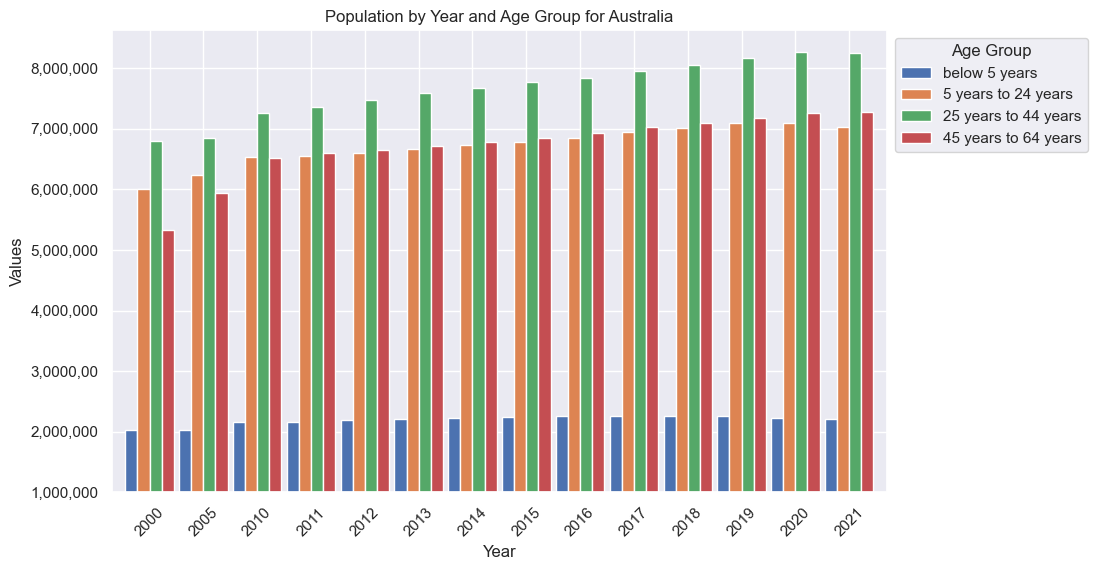

In [14]:
df_plot = country_pop_procced_df.unstack().sort_index(level=1, axis=1)
# Plotting
ax = df_plot.plot(kind='bar', width=0.9, figsize=(10, 6), rot=45)

ax.set_ylabel('Values')
ax.set_title(f'Population by Year and Age Group for {selected_country}')
y_ticks = ['1,000,000', '2,000,000', '3,0000,00', '4,000,000', '5,000,000', '6,000,000', '7,000,000', '8,000,000', '9,000,000', '10,000,000']
ax.set_yticklabels(y_ticks)

# Adding legend
plt.legend(title='Age Group', bbox_to_anchor=(1, 1), labels=ages_list)

# Show the plot
plt.show()